In [4]:
import os
import random
import numpy as np
import pandas as pd
import glob
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
warnings.filterwarnings('ignore')

In [ ]:
# ---- GLOBAL SETTINGS ----
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

IMG_SIZE = 64
BATCH = 16
EPOCHS = 50
PATIENCE = 5

train_path = r"C:\Users\LT\Desktop\Licencjat\train"
test_path  = r"C:\Users\LT\Desktop\Licencjat\test"

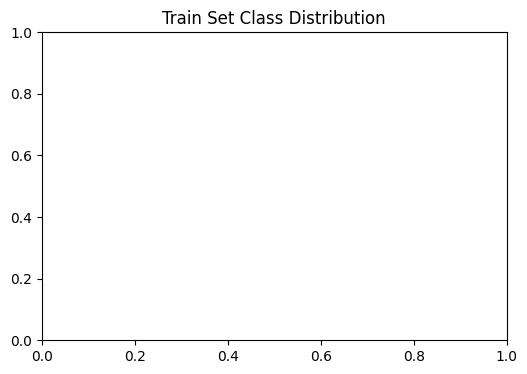

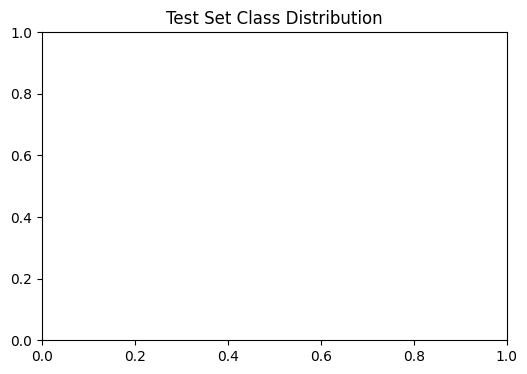

In [6]:
# ---- DATA LOADING ----
def get_all_images(folder, label):
    return glob.glob(os.path.join(folder, label, "*.jpeg"))

train_normal_imgs = get_all_images(train_path, "NORMAL")
train_pneumonia_imgs = get_all_images(train_path, "PNEUMONIA")
test_normal_imgs = get_all_images(test_path, "NORMAL")
test_pneumonia_imgs = get_all_images(test_path, "PNEUMONIA")

train_imgs = train_normal_imgs + train_pneumonia_imgs
train_labels = ["Normal"] * len(train_normal_imgs) + ["Pneumonia"] * len(train_pneumonia_imgs)
test_imgs = test_normal_imgs + test_pneumonia_imgs
test_labels = ["Normal"] * len(test_normal_imgs) + ["Pneumonia"] * len(test_pneumonia_imgs)

df_train = pd.DataFrame({"image": train_imgs,  "class": train_labels})
df_test  = pd.DataFrame({"image": test_imgs,   "class": test_labels})

# ---- CLASS DISTRIBUTION ----
plt.figure(figsize=(6, 4))
sns.countplot(x='class', data=df_train, palette="mako")
plt.title('Train Set Class Distribution')
plt.show()

plt.figure(figsize=(6, 4))
sns.countplot(x='class', data=df_test, palette="mako")
plt.title('Test Set Class Distribution')
plt.show()

In [7]:
# ---- IMAGE PREVIEW ----
def show_images(df, dataset_name, target_class):
    print(f"{dataset_name} - {target_class}")
    filtered_df = df[df['class'] == target_class].reset_index(drop=True)
    plt.figure(figsize=(12, 12))
    for i in range(min(12, len(filtered_df))):
        plt.subplot(3, 4, i+1)
        img = cv2.imread(filtered_df.loc[i, 'image'])
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

show_images(df_train, "Train Set", "Normal")
show_images(df_train, "Train Set", "Pneumonia")
show_images(df_test, "Test Set", "Normal")
show_images(df_test, "Test Set", "Pneumonia")


Train Set - Normal


<Figure size 1200x1200 with 0 Axes>

Train Set - Pneumonia


<Figure size 1200x1200 with 0 Axes>

Test Set - Normal


<Figure size 1200x1200 with 0 Axes>

Test Set - Pneumonia


<Figure size 1200x1200 with 0 Axes>

In [ ]:
# ---- TRAIN/VAL SPLIT ----
train_df, val_df = train_test_split(
    df_train, test_size=0.2, 
    stratify=df_train["class"], random_state=42
    )

In [ ]:
# ---- IMAGE GENERATORS ----
train_gen = ImageDataGenerator(
    rescale=1/255.,
    rotation_range=25,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    brightness_range=[0.7, 1.3]
)
val_gen = ImageDataGenerator(rescale=1/255.)

ds_train = train_gen.flow_from_dataframe(
    train_df, x_col="image", y_col="class",
    class_mode="binary", target_size=(IMG_SIZE,IMG_SIZE),
    batch_size=BATCH, shuffle=True
)
ds_val = val_gen.flow_from_dataframe(
    val_df, x_col="image", y_col="class",
    class_mode="binary", target_size=(IMG_SIZE,IMG_SIZE),
    batch_size=BATCH, shuffle=False
)
ds_test = val_gen.flow_from_dataframe(
    df_test, x_col="image", y_col="class",
    class_mode="binary", target_size=(IMG_SIZE,IMG_SIZE),
    batch_size=1, shuffle=False
)


In [ ]:
# ---- CNN MODEL ----
model = models.Sequential([
    layers.Input((IMG_SIZE, IMG_SIZE, 3)),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPool2D(),

    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPool2D(),

    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPool2D(),

    layers.Flatten(),
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.5),

    layers.Dense(1, activation='sigmoid')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)
model.summary()


In [ ]:
# ---- CALLBACKS ----
early_stopping = EarlyStopping(
    monitor='val_loss', patience=PATIENCE,
    restore_best_weights=True
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', factor=0.3, patience=2,
    min_lr=1e-7, verbose=1
)


In [ ]:
# ---- TRAINING ----
history = model.fit(
    ds_train,
    epochs=EPOCHS,
    steps_per_epoch=len(train_df) // BATCH,
    validation_data=ds_val,
    validation_steps=len(val_df) // BATCH,
    callbacks=[early_stopping, reduce_lr]
)

In [ ]:
# ---- LEARNING CURVES ----
plt.figure(figsize=(10, 6))
sns.lineplot(x=range(len(history.history['accuracy'])), y=history.history['accuracy'], label='Train Accuracy')
sns.lineplot(x=range(len(history.history['val_accuracy'])), y=history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Learning Curve - Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
sns.lineplot(x=range(len(history.history['loss'])), y=history.history['loss'], label='Train Loss')
sns.lineplot(x=range(len(history.history['val_loss'])), y=history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve - Loss')
plt.legend()
plt.show()


In [ ]:
# ---- FINAL EVALUATION ----
val_loss, val_acc = model.evaluate(ds_val, steps=len(val_df)//BATCH, verbose=0)
print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")

test_loss, test_acc = model.evaluate(ds_test, steps=len(df_test), verbose=0)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")


In [ ]:
# ---- CONFUSION MATRIX ----
true_labels = df_test['class'].map({'Normal': 0, 'Pneumonia': 1}).values
pred_probs = model.predict(ds_test, steps=len(df_test), verbose=0).flatten()
pred_labels = np.where(pred_probs > 0.5, 1, 0)


In [ ]:
cm = confusion_matrix(true_labels, pred_labels)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Test Set')
plt.show()


In [ ]:
# ---- ROC CURVE + AUC ----
roc_auc = roc_auc_score(true_labels, pred_probs)
fpr, tpr, thresholds = roc_curve(true_labels, pred_probs)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'ROC AUC = {roc_auc:.3f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Test Set')
plt.legend(loc='lower right')
plt.show()